In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
device = torch.device("cpu")

In [4]:
!ls black_and_white

train  val


In [5]:
!ls black_and_white/train

black  blacktumbler  silver  white


In [7]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ]) # try jittervalue 1


transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ])

training_dataset = datasets.ImageFolder('black_and_white/train', transform = transform_train)
validation_dataset = datasets.ImageFolder('black_and_white/val', transform = transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [8]:
print("train_len:", len(training_dataset))
print("val_len:", len(validation_dataset))

train_len: 198
val_len: 56


In [9]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [10]:
classes = ['black', 'blacktumbler', 'silver', 'white']

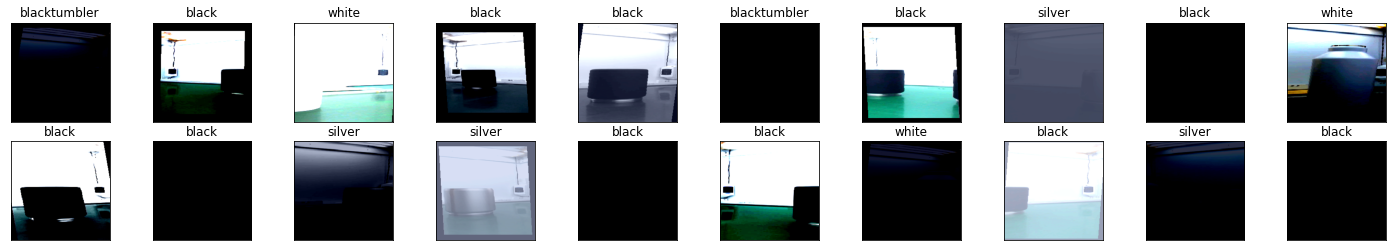

In [11]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [12]:
model = models.alexnet(pretrained=True)

In [13]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
for param in model.features.parameters():
  param.requires_grad = False

In [15]:
import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

4


In [16]:
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # try different learning rates to see how model works, lower learning rate cause overfiting

In [18]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)


  else:
    with torch.no_grad():
     for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)

      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)


    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch:', (e+1))
    print('training loss: {:.4f}, acc{:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss: 0.0587, acc0.5657
validation loss: 0.0373, validation acc0.8929
epoch: 2
training loss: 0.0373, acc0.7525
validation loss: 0.0157, validation acc0.9107
epoch: 3
training loss: 0.0292, acc0.8030
validation loss: 0.0188, validation acc0.9464
epoch: 4
training loss: 0.0252, acc0.8384
validation loss: 0.0071, validation acc0.9643
epoch: 5
training loss: 0.0194, acc0.8384
validation loss: 0.0097, validation acc0.9643
epoch: 6
training loss: 0.0136, acc0.8939
validation loss: 0.0129, validation acc0.9286
epoch: 7
training loss: 0.0187, acc0.8939
validation loss: 0.0205, validation acc0.9286
epoch: 8
training loss: 0.0154, acc0.8990
validation loss: 0.0058, validation acc0.9643
epoch: 9
training loss: 0.0151, acc0.8990
validation loss: 0.0083, validation acc0.9821
epoch: 10
training loss: 0.0126, acc0.9040
validation loss: 0.0135, validation acc0.8929


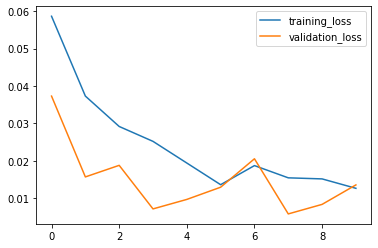

In [19]:
plt.plot(running_loss_history, label = "training_loss")
plt.plot(val_running_loss_history, label = "validation_loss")
plt.legend()

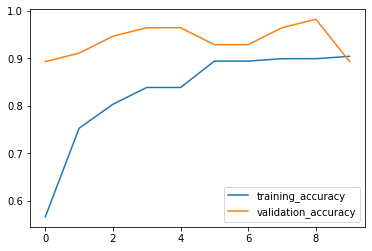

In [20]:
plt.plot(running_corrects_history, label = "training_accuracy")
plt.plot(val_running_corrects_history, label = "validation_accuracy")
plt.legend()

In [21]:
!pip3 install pillow==5.2.0

  Using cached Pillow-5.2.0.tar.gz (14.5 MB)
Using legacy 'setup.py install' for pillow, since package 'wheel' is not installed.
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
    Running setup.py install for pillow ... done
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

matplotlib 3.5.0 requires pillow>=6.2.0, but you'll have pillow 5.2.0 which is incompatible.
You should consider upgrading via the '/home/lihang/chenggui/811test/.env/bin/python3.8 -m pip install --upgrade pip' command.


In [22]:
import PIL.ImageOps

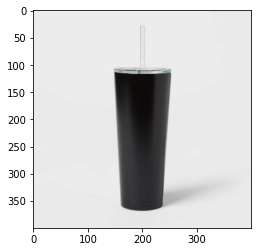

In [23]:
import requests
from PIL import Image

# test an blacktumbler bottle
img1 = Image.open(r'test/1.jpg')
plt.imshow(img1)

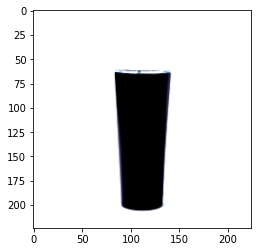

In [24]:
img1 = transform(img1)
plt.imshow(im_convert(img1))

In [25]:
# Check the predicted type of blacktumbler bottle
image1 = img1.to(device).unsqueeze(0)
output = model(image1)
_, pred = torch.max(output, 1)
print(f'Predicted Class: {classes[pred.item()]}')
print('Actual Class: Blacktumbler')

Predicted Class: black
Actual Class: Blacktumbler


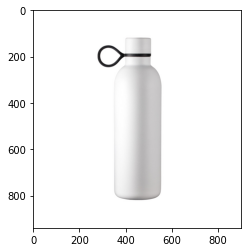

In [26]:
import requests
from PIL import Image

img2 = Image.open(r'test/3.jpg')
plt.imshow(img2)

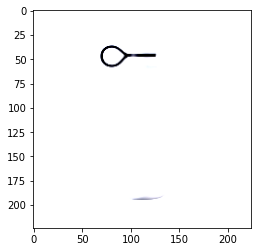

In [27]:
img2 = transform(img2)
plt.imshow(im_convert(img2))

In [28]:
image2 = img2.to(device).unsqueeze(0)
output = model(image2)
_, pred = torch.max(output, 1)
print(f'Predicted Class: {classes[pred.item()]}')
print('Actual Class: white')

Predicted Class: silver
Actual Class: white


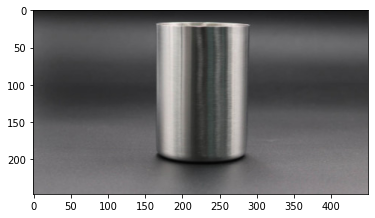

In [30]:
import requests
from PIL import Image

img3 = Image.open(r'test/2.jpg')
plt.imshow(img2)

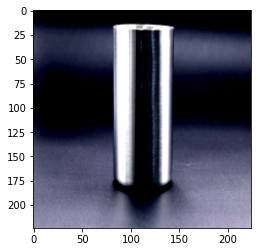

In [31]:
img2 = transform(img2)
plt.imshow(im_convert(img2))

In [32]:
image2 = img2.to(device).unsqueeze(0)
output = model(image2)
_, pred = torch.max(output, 1)
print(f'Predicted Class: {classes[pred.item()]}')
print('Actual Class: white')

Predicted Class: silver
Actual Class: white


*** Conclusion:
1. The accuaries of trained model will decrease when the number of bottle classes increases.
2. Although training and test accuracies are around 90%, but because the dataset is small and the number of class is limited. The model didn't work very well when new bottle images needs to be classified.
3. Trained AlexNet is not able to correctly identify bottles with a little bit variation in shape or color.
4. If a bigger dataset with more classes is used, AlexNet becomes very slow, which has been tested with CIFAR100 and CIFAR10.

